<a href="https://colab.research.google.com/github/maruvadaItis/MovieMahal/blob/master/searchphase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer,ENGLISH_STOP_WORDS
from ast import literal_eval
from sklearn.metrics.pairwise import linear_kernel
from matplotlib.pyplot import figure, gca, xlabel, barh, title
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from nltk.stem import WordNetLemmatizer



In [212]:
lv1 = pd.read_csv('tmdb_5000_credits.csv')
lv2 = pd.read_csv('tmdb_5000_movies.csv')
lv1.columns = ['id', 'tittle', 'cast', 'crew']
lv2 = lv2.merge(lv1, on='id')
print(lv2.head(5))

      budget  ...                                               crew
0  237000000  ...  [{"credit_id": "52fe48009251416c750aca23", "de...
1  300000000  ...  [{"credit_id": "52fe4232c3a36847f800b579", "de...
2  245000000  ...  [{"credit_id": "54805967c3a36829b5002c41", "de...
3  250000000  ...  [{"credit_id": "52fe4781c3a36847f81398c3", "de...
4  260000000  ...  [{"credit_id": "52fe479ac3a36847f813eaa3", "de...

[5 rows x 23 columns]


In [213]:
C = lv2['vote_average'].mean()
print(C)

6.092171559442011


In [214]:
m = lv2['vote_count'].quantile(0.9)
print(m)

1838.4000000000015


In [225]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']

    return (v / (v + m) * R) + (m / (m + v) * C)

lv2['score'] = lv2.apply(weighted_rating, axis=1)
lv2 = lv2.sort_values('score', ascending=False)
print(lv2[['title', 'vote_count', 'vote_average', 'score']].head(10))

                                           title  ...     score
0                       The Shawshank Redemption  ...  8.059258
1                                     Fight Club  ...  7.939256
2                                The Dark Knight  ...  7.920020
3                                   Pulp Fiction  ...  7.904645
4                                      Inception  ...  7.863239
5                                  The Godfather  ...  7.851236
6                                   Interstellar  ...  7.809479
7                                   Forrest Gump  ...  7.803188
8  The Lord of the Rings: The Return of the King  ...  7.727243
9                        The Empire Strikes Back  ...  7.697884

[10 rows x 4 columns]


Text(0.5, 0, 'Popularity')
Text(0.5, 1.0, 'Popular Movies')
0    Framed in the 1940s for the double murder of h...
1    A ticking-time-bomb insomniac and a slippery s...
2    Batman raises the stakes in his war on crime. ...
3    A burger-loving hit man, his philosophical par...
4    Cobb, a skilled thief who commits corporate es...
5    Spanning the years 1945 to 1955, a chronicle o...
6    Interstellar chronicles the adventures of a gr...
7    A man with a low IQ has accomplished great thi...
8    Aragorn is revealed as the heir to the ancient...
9    The epic saga continues as Luke Skywalker, in ...
Name: overview, dtype: object


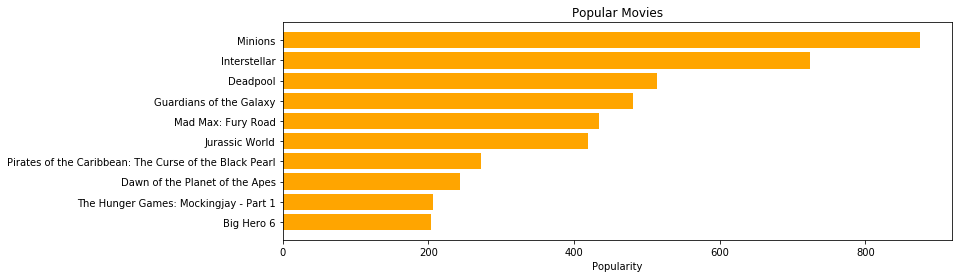

In [224]:
pop = lv2.sort_values('popularity', ascending=False)
figure(figsize=(12, 4))
barh(pop['title'].head(10), pop['popularity'].head(10), align='center', color='orange')
gca().invert_yaxis()
print(xlabel("Popularity"))
print(title("Popular Movies"))
print(lv2['overview'].head(10))

In [217]:
tfidf = TfidfVectorizer(stop_words="english")
lv2['overview'] = lv2['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(lv2['overview'])
print(tfidf_matrix.shape)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(lv2.index, index=lv2['title']).drop_duplicates()

(4803, 20978)


In [0]:
def remove_stop_words(tokens):
    all_tokens = tokens.split(" ")
    stop_words = ENGLISH_STOP_WORDS
    lemmatizer = WordNetLemmatizer()

    tokens_without_stop_words = [x for x in all_tokens if x not in stop_words]

    tokens_after_preprocess = []
    print(tokens_without_stop_words)
    for word in tokens_without_stop_words:
        print("LOLWA: ",word)
        tokens_after_preprocess.append(lemmatizer.lemmatize(word))

    return tokens_after_preprocess


In [0]:
def get_movierecomm(title, cosine_sim=cosine_sim):
    print("DEB : " , title,"\n Type : ", type(indices))
    # # title = remove_stop_words(title)
    # temp = indices[indices['title'].str.contains(title)]
    if title in indices:
      idx = indices[title]
      sim_scores = list(enumerate(cosine_sim[idx]))
      sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
      sim_scores = sim_scores[1:11]
      
      movie_indices = [i[0] for i in sim_scores]
      return lv2['title'].iloc[movie_indices]

    else:
      df = pd.DataFrame(indices).reset_index()[["title"]]
      temp = df[df['title'].str.contains(title)]["title"].iloc[0]
      return get_movierecomm(temp)

In [220]:
features = ['cast', 'crew', 'keywords', 'genres','production_companies']
for feature in features:
    lv2[feature] = lv2[feature].apply(literal_eval)

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names
    return []
lv2['director'] = lv2['crew'].apply(get_director)
features = ['cast', 'keywords', 'genres','production_companies']
for feature in features:
    lv2[feature] = lv2[feature].apply(get_list)
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:

        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
features = ['cast', 'keywords', 'director', 'genres','production_companies']

for feature in features:
    lv2[feature] = lv2[feature].apply(clean_data)
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres']) + ' ' + ' '.join(x['production_companies'])
lv2['soup'] = lv2.apply(create_soup, axis=1)
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(lv2['soup'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
lv2 = lv2.reset_index()
indices = pd.Series(lv2.index, index=lv2['title'])
# indices = pd.DataFrame(indices).reset_index()[["title"]]
inputde = input("Enter the movie name:")

print(get_movierecomm(inputde,cosine_sim2))
# remove_stop_words(inputde)

Enter the movie name:Iron Man
DEB :  Iron Man 
 Type :  <class 'pandas.core.series.Series'>
451                              Iron Man 2
279                              Iron Man 3
68                             The Avengers
128                 Avengers: Age of Ultron
173              Captain America: Civil War
213                                 Ant-Man
447      Captain America: The First Avenger
64      Captain America: The Winter Soldier
2915                    The Helix... Loaded
1090                           TRON: Legacy
Name: title, dtype: object
